In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import re

In [78]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.8

## Get info to make pairs

In [79]:
# Load study information
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir =os.path.join(outdir, 'figures/ControlPairs/')
gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned.txt'), sep='\t')

In [80]:
# Load trait lists
traitlists={}
for group, file in {'NG':'testing/nearestGene.traitlist', 'NG8':'testing/nearestGeneTH8.traitlist', 
                    'MAG103':'magma/magma_th103.traitlist', 'MAG256':'magma/magma_th256.traitlist', 'MAGall':'magma/magma_all.traitlist'}.items():
    traitlists[group] = pd.read_csv(os.path.join(datadir, 'inputs', file), sep='\t', header=None, names=['ID'])
    traitlists[group] = traitlists[group].assign(EFO=traitlists[group].ID.apply(lambda z: next((match.group() for match in re.finditer(r'EFO_\d+', z)), None)))
    traitlists[group] = traitlists[group].assign(Study=traitlists[group].ID.apply(lambda z: next((match.group() for match in re.finditer(r'GCST\d+', z)), None)))

In [81]:
study_dict = gwas_study.set_index('STUDY ACCESSION')['DISEASE/TRAIT'].to_dict()

In [82]:
for group, df in traitlists.items():
    traitlists[group] = df.assign(Trait=df.Study.map(study_dict))

In [83]:
for group, df in traitlists.items():
    df.to_csv(os.path.join(outdir, f'{group}.traits.tsv'), sep='\t', index=False)

## Load results

In [85]:
file_lists = {'nearestGene': {'base':2029530, 'max':2029531, 'sum':2029532, 'binary':2029542},#, 'log':2065731, 'minmax':2065732},
             'nearestGeneTH8': {'base':2029476, 'max':2029507, 'sum':2029518, 'binary':2029519},#, 'log':2065735, 'minmax':2065736},
             'magma_th103':{'base':2029545, 'max':2029556, 'sum':2029557, 'binary':2029558},#, 'log': 2065733, 'minmax':2065734},
             'magma_th256': {'base':2034463, 'max':2029569, 'sum':2029579, 'binary':2029580},#, 'log':2065738, 'minmax':2065740},
             'magma_all': {'base':2030529, 'max':2030587, 'sum':2030601}}
results = {x: {} for x in file_lists}

In [86]:
not_found = []
for x, y in file_lists.items():
    print(x)
    for z,  job_id in y.items():
        if 'magma' in x:
            with open(os.path.join(datadir, 'outputs', 'netcoloc', 'magma', f'{job_id}.files'), 'r') as f:
                filenames = [s.strip() for s in f.readlines()]
            loaded_data = []
            for f in filenames:
                try:
                    loaded_data.append(pd.read_csv(os.path.join(datadir, 'outputs', 'netcoloc', 'magma', f), sep='\t', header=None))
                except FileNotFoundError:
                    not_found.append(os.path.join(datadir, 'outputs', 'netcoloc', 'magma', f))
        else:
            with open(os.path.join(datadir, 'outputs', 'netcoloc', 'testing', f'{job_id}.files'), 'r') as f:
                filenames = [s.strip() for s in f.readlines()]
            loaded_data = []
            for f in filenames:
                try:
                    loaded_data.append(pd.read_csv(os.path.join(datadir, 'outputs', 'netcoloc', 'testing', f), sep='\t', header=None))
                except FileNotFoundError:
                    not_found.append(f)
        results[x][z] = pd.concat(loaded_data)
        results[x][z].columns = ['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 
                                 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
        results[x][z]['Group'] = x
        results[x][z]['Norm'] = z
        results[x][z]['logp_nps'] = results[x][z].P_mean_NPS.apply(lambda x: -1 * np.log10(x+1e-250))
        results[x][z]['logp_size'] = results[x][z].P_size.apply(lambda x: -1 * np.log10(x+1e-250))
        results[x][z]['SizeOE'] = np.log2(results[x][z]['Size'] / results[x][z]['Null_Size'])
        results[x][z]['Set'] = 'Control'
        results[x][z]['FullTrait'] = results[x][z].apply(lambda a: '_'.join([a.TraitR, a.TraitC]), axis=1)

nearestGene
nearestGeneTH8
magma_th103
magma_th256
magma_all


In [87]:
ng = pd.concat(results['nearestGene'].values())
ng8 = pd.concat(results['nearestGeneTH8'].values())
mag103 = pd.concat(results['magma_th103'].values())
mag256 = pd.concat(results['magma_th256'].values())
magAll = pd.concat(results['magma_all'].values())

## Plots of control statistics

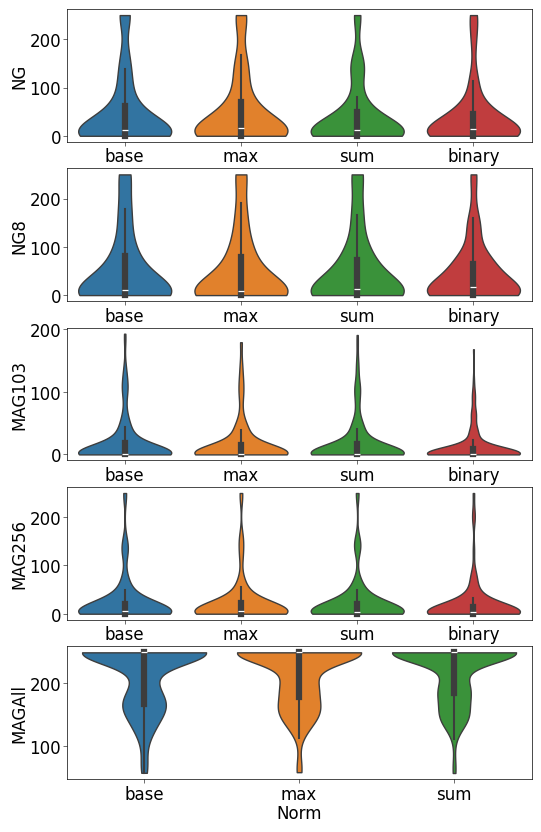

In [89]:
_, axs = plt.subplots(nrows=5, ncols=1, figsize=(6, 10))
labels = ['NG', 'NG8', 'MAG103', 'MAG256', 'MAGAll']
for i, df in enumerate([ng, ng8, mag103, mag256, magAll]):
    sns.violinplot(df.reset_index(), y='logp_nps',x='Norm', ax=axs[i], hue='Norm', cut=0)
    axs[i].set_ylabel(labels[i])

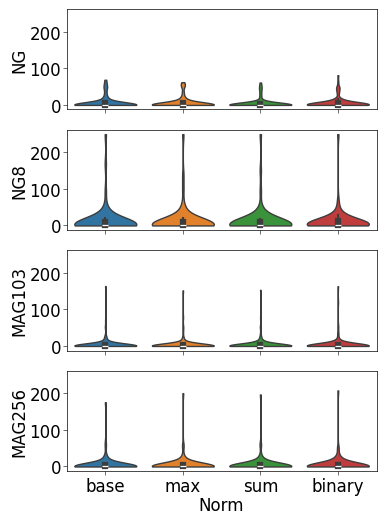

In [91]:
_, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharex=True, sharey=True)
labels = ['NG', 'NG8', 'MAG103', 'MAG256']
for i, df in enumerate([ng, ng8, mag103, mag256]):
    sns.violinplot(df.reset_index(), y='logp_size', ax=axs[i], x='Norm',hue='Norm',cut=0)
    axs[i].set_ylabel(labels[i])

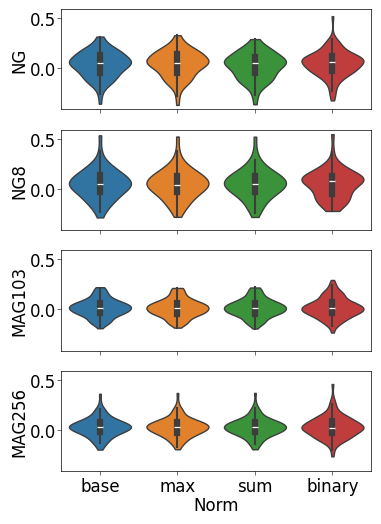

In [92]:
_, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharex=True, sharey=True)
labels = ['NG', 'NG8', 'MAG103', 'MAG256']
for i, df in enumerate([ng, ng8, mag103, mag256]):
    sns.violinplot(df.reset_index(), y='Mean_NPS', ax=axs[i], x='Norm',hue='Norm',cut=0)
    axs[i].set_ylabel(labels[i])

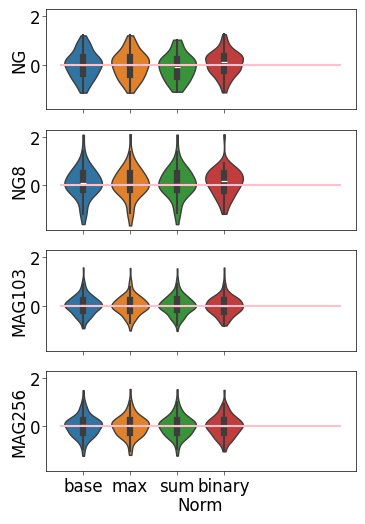

In [93]:
_, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharex=True, sharey=True)
labels = ['NG', 'NG8', 'MAG103', 'MAG256']
for i, df in enumerate([ng, ng8, mag103, mag256]):
    sns.violinplot(df.reset_index(), y='SizeOE', ax=axs[i], x='Norm',hue='Norm', cut=0)
    axs[i].set_ylabel(labels[i])
    axs[i].hlines(y=0, xmin=-.5, xmax=5.5, color='pink')

## Load actual statistics

In [94]:
all_results = pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/ng_magma_testing_results_within.tsv', 
                  sep='\t')
all_results['SizeOE'] = np.log2(all_results['Size']/all_results['Null_Size'])

In [97]:
all_results = all_results[all_results.Norm.isin(['Binary', 'Base', 'max', 'sum'])]

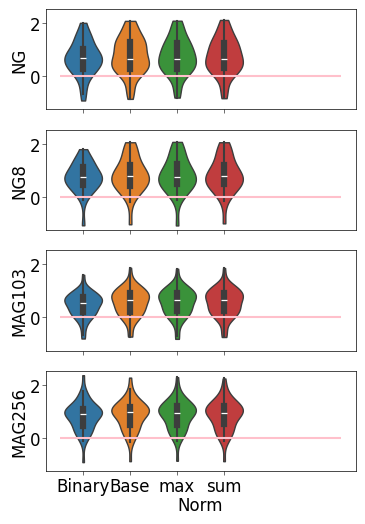

In [98]:
_, axs = plt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharex=True, sharey=True)
labels = ['NG', 'NG8', 'MAG103', 'MAG256']
for i, group in enumerate(['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']):
    sns.violinplot(all_results[all_results.Group==group], y='SizeOE', ax=axs[i], x='Norm',hue='Norm', 
                   hue_order= ['Binary', 'Base', 'max', 'sum',], cut=0)
    axs[i].set_ylabel(labels[i])
    axs[i].hlines(y=0, xmin=-.5, xmax=5.5, color='pink')

## Plots comparing statistics

In [99]:
all_results.Norm = all_results.Norm.map({'max':'max', 'Base':'base', 'sum':'sum', 'log':'log',
                                         'zscore':'zscore', 'minmax':'minmax', 'Binary':'binary'})

In [100]:
all_results.Group.unique()
all_results['Set'] = 'Test'
all_results = all_results.rename(columns={'logPSize':'logp_size', 'logPNPS': 'logp_nps'})

In [101]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

def calculate_auc(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Calculate the AUC for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: AUC scores for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        y_true = group[control_col].apply(lambda x: 1 if x == control_labels[0] else 0)
        try:
            auc_score = roc_auc_score(y_true, group[value_col])
        except:
            return y_true, group[value_col]
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'AUC': auc_score
        })
    
    return pd.DataFrame(results)


def perform_mann_whitney(df_in, value_col, processing_col, normalization_col, control_col, control_labels):
    """
    Perform Mann-Whitney U test for each combination of processing and normalization methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the score values.
        processing_col (str): Column specifying input processing methods.
        normalization_col (str): Column specifying normalization methods.
        control_col (str): Column indicating positive/negative controls.
        control_labels (tuple): Tuple with positive and negative labels (e.g., ('positive', 'negative')).

    Returns:
        pd.DataFrame: Mann-Whitney U test statistics and p-values for each method combination.
    """
    results = []
    df = df_in.copy().dropna(subset=value_col)
    for (proc, norm), group in df.groupby([processing_col, normalization_col]):
        pos_scores = group[group[control_col] == control_labels[0]][value_col]
        neg_scores = group[group[control_col] == control_labels[1]][value_col]
        try:
            u_stat, p_value = mannwhitneyu(pos_scores, neg_scores, alternative='greater')
        except:
            return group, pos_scores, neg_scores
        results.append({
            processing_col: proc,
            normalization_col: norm,
            'U_statistic': u_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)


I think I need to restrict to shared traits in order to compare across methods. Because what if one is being biased by higher or lower quality inputs?
What threshold does binary use?

In [103]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
groups = {'nearestGene':ng, 'nearestGeneTH8':ng8, 'magma_th103':mag103, 'magma_th256':mag256}
results = []
for stat in stats:
    for g, g_df in groups.items():
        test_df = all_results[all_results.Group==g]
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts>=4].index.values
        #print(len(use_studies)/len(study_counts))
        test_df = test_df[test_df.Study.isin(use_studies)]
        control_df = g_df.copy()
        control_counts = g_df[~g_df[stat].isna()].FullTrait.value_counts()
        use_controls= control_counts[control_counts>=4].index.values
        control_df = control_df[control_df.FullTrait.isin(use_controls)]
        df = pd.concat([test_df, g_df]).reset_index()

        auc = calculate_auc(df, value_col=stat, processing_col='Group', normalization_col='Norm', 
                            control_col='Set', control_labels=('Test', 'Control'))
        mannu = perform_mann_whitney(df, value_col=stat, processing_col='Group', normalization_col='Norm', 
                                   control_col='Set', control_labels=('Test', 'Control'))
        res = auc.merge(mannu, on=['Group', 'Norm'], how='outer')
        res['stat'] = stat
        results.append(res)
res_df = pd.concat(results)

In [105]:
res_df[res_df.Group=='magma_th256']

,Group,Norm,AUC,U_statistic,p_value,stat
0,magma_th256,base,0.844853,3447.0,2.207335e-11,Mean_NPS
1,magma_th256,binary,0.843750,3564.0,1.924566e-11,Mean_NPS
2,magma_th256,max,0.846065,3655.0,1.186986e-11,Mean_NPS
3,magma_th256,sum,0.845139,3651.0,1.340837e-11,Mean_NPS
0,magma_th256,base,0.855945,3419.5,5.926908e-12,logp_nps
1,magma_th256,binary,0.854691,3535.0,5.524688e-12,logp_nps
2,magma_th256,max,0.856028,3621.0,3.607949e-12,logp_nps
3,magma_th256,sum,0.855319,3618.0,3.897555e-12,logp_nps
0,magma_th256,base,0.883824,3606.0,1.113904e-13,SizeOE
1,magma_th256,binary,0.885653,3741.0,6.045284e-14,SizeOE


In [106]:
res_df.head()

,Group,Norm,AUC,U_statistic,p_value,stat
0,nearestGene,base,0.791353,3789.0,2.335055e-09,Mean_NPS
1,nearestGene,binary,0.762319,3156.0,2.972706e-07,Mean_NPS
2,nearestGene,max,0.773169,2703.0,2.299902e-07,Mean_NPS
3,nearestGene,sum,0.806763,2338.0,2.499716e-08,Mean_NPS
0,nearestGeneTH8,base,0.785632,1367.0,6.194420e-06,Mean_NPS


### Control plot

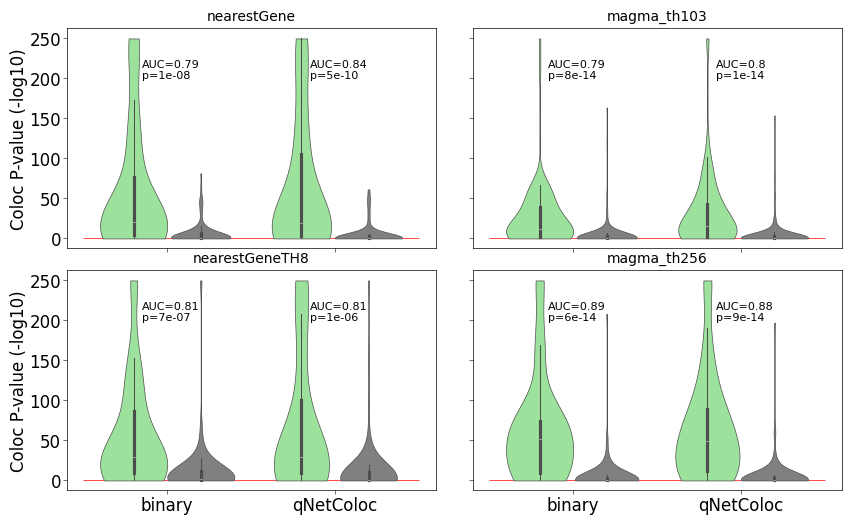

In [108]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
for i, group in enumerate(control_groups.keys()):
    df = pd.concat([all_results[all_results.Group==group], control_groups[group]]).reset_index()
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc', 'log':'Q-log', 'minmax': 'Q-mm'})
    sns.violinplot(df, y='logp_size', x='Norm',hue='Set',cut=0, ax=[ax1, ax2, ax3,ax4][i], linewidth=0.5, 
                   palette=['lightgreen', 'grey'], order=['binary','qNetColoc'],  zorder=1, legend=False)
    [ax1,ax2,ax3,ax4][i].hlines(y=0, xmin=-0.5, xmax=1.5, color='red', zorder=0, linewidth=0.5,)
    [ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel('Coloc P-value (-log10)')
    for j, norm in enumerate(['binary', 'sum',]):
        auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_size')].AUC.values[0])
        p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_size')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=200, s=f'AUC={auc}\np={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'SizeP_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

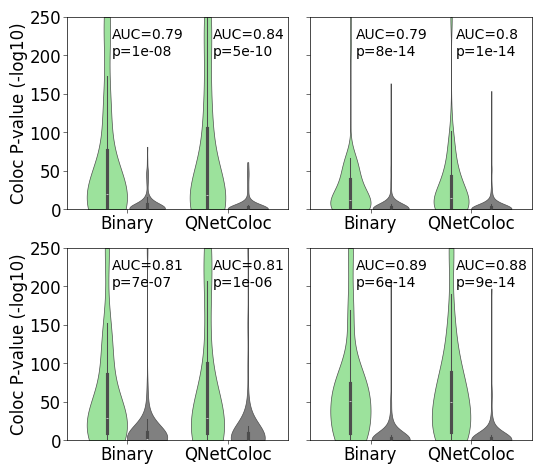

In [109]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6, 5.5), sharex=False, sharey=True, 
                                           gridspec_kw={'hspace':0.2, 'wspace':0.1})
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
for i, group in enumerate(control_groups.keys()):
    df = pd.concat([all_results[all_results.Group==group], control_groups[group]]).reset_index()
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    df['HueGroup']= df['Norm'] + df['Set']
    sns.violinplot(df, y='logp_size', x='Norm',hue='Set',cut=0, ax=[ax1, ax2, ax3,ax4][i], linewidth=0.5, 
                   palette=['lightgreen', 'grey'], order=['binary','qNetColoc', 'Q-log', 'Q-mm'],zorder=1, legend=False)
    [ax1,ax2,ax3,ax4][i].hlines(y=0, xmin=-0.5, xmax=1.5, color='black', zorder=0, linewidth=0.5,)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel('Coloc P-value (-log10)')
    [ax1,ax2,ax3,ax4][i].set_xticks([0,1], ['Binary', 'QNetColoc'])
    [ax1,ax2,ax3,ax4][i].set_ylim((0,250))
    for j, norm in enumerate(['binary', 'sum']):
        auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_size')].AUC.values[0])
        p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_size')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=200, s=f'AUC={auc}\np={p}', fontsize=10)
plt.savefig(os.path.join(figdir,'SizeP_Control_Test_violins.svg'), dpi=400, bbox_inches='tight')

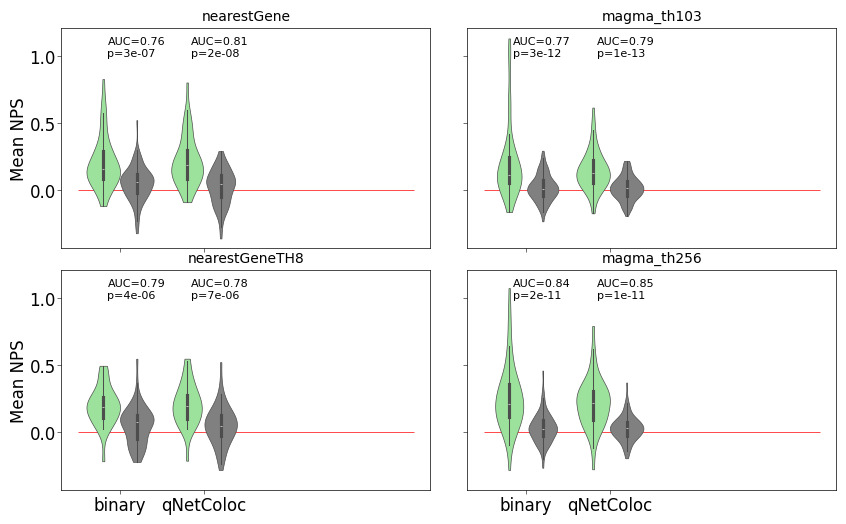

In [110]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
for i, group in enumerate(control_groups.keys()):
    df = pd.concat([all_results[all_results.Group==group], control_groups[group]]).reset_index()
    df = df[df.Norm.isin(['binary', 'sum', 'log', 'minmax'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc', 'log':'Q-log', 'minmax': 'Q-mm'})
    sns.violinplot(df, y='Mean_NPS', x='Norm',hue='Set',cut=0, ax=[ax1, ax2, ax3,ax4][i], linewidth=0.5, 
                   palette=['lightgreen', 'grey'], zorder=1, legend=False,  order=['binary','qNetColoc',])
    [ax1,ax2,ax3,ax4][i].hlines(y=0, xmin=-0.5, xmax=3.5, color='red', zorder=0, linewidth=0.5,)
    [ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel('Mean NPS')
    for j, norm in enumerate(['binary', 'sum']):
        auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='Mean_NPS')].AUC.values[0])
        p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='Mean_NPS')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=1, s=f'AUC={auc}\np={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'MeanNPS_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

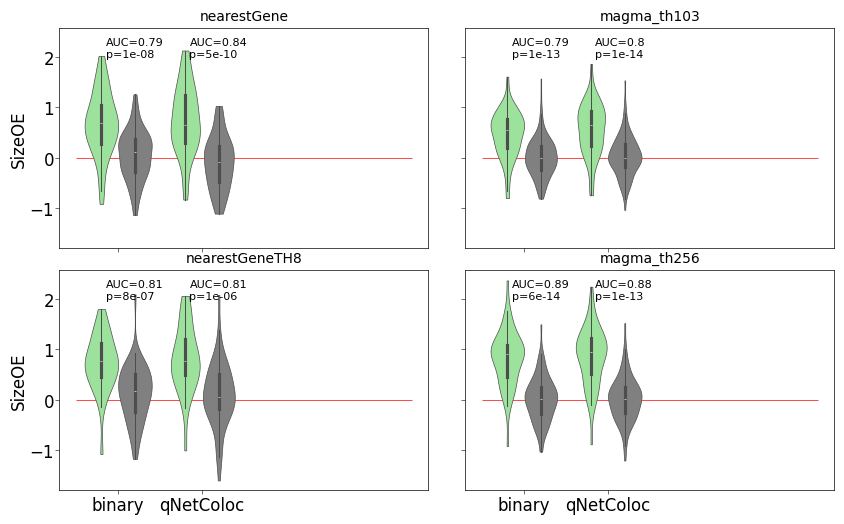

In [111]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
stat = 'SizeOE'
for i, group in enumerate(control_groups.keys()):
    df = pd.concat([all_results[all_results.Group==group], control_groups[group]]).reset_index()
    df = df[df.Norm.isin(['binary', 'sum', 'log', 'minmax'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc', 'log':'Q-log', 'minmax': 'Q-mm'})
    sns.violinplot(df, y=stat, x='Norm',hue='Set',cut=0, ax=[ax1, ax2, ax3,ax4][i], linewidth=0.5, 
                   palette=['lightgreen', 'grey'], zorder=1, legend=False,order=['binary','qNetColoc'])
    [ax1,ax2,ax3,ax4][i].hlines(y=0, xmin=-0.5, xmax=3.5, color='red', zorder=0, linewidth=0.5,)
    [ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel(stat)
    for j, norm in enumerate(['binary', 'sum']):
        auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat==stat)].AUC.values[0])
        p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat==stat)].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=2, s=f'AUC={auc}\np={p}', fontsize=8)
plt.savefig(os.path.join(figdir,'log2SizeOE_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

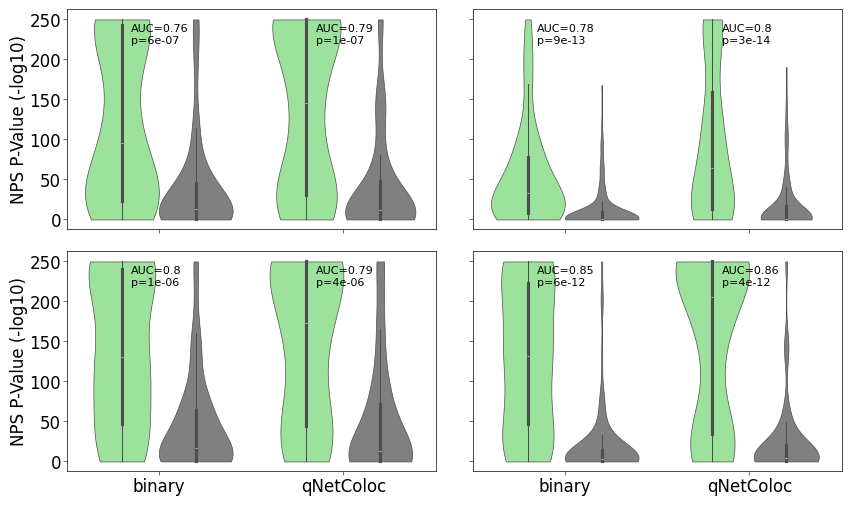

In [113]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex=True, sharey=True,
                                          gridspec_kw={'hspace':0.1, 'wspace':0.1})
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
for i, group in enumerate(control_groups.keys()):
    df = pd.concat([all_results[all_results.Group==group], control_groups[group]]).reset_index()
    df = df[df.Norm.isin(['binary', 'sum', 'log', 'minmax'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc', 'log':'Q-log', 'minmax': 'Q-mm'})
    sns.violinplot(df, y='logp_nps', x='Norm',hue='Set',cut=0, ax=[ax1, ax2, ax3,ax4][i], linewidth=0.5, 
                   palette=['lightgreen', 'grey'], zorder=1, legend=False,order=['binary','qNetColoc'])
    #[ax1,ax2,ax3,ax4][i].hlines(y=1, xmin=-0.5, xmax=1.5, color='red', zorder=0, linewidth=0.5,)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel('NPS P-Value (-log10)')
    for j, norm in enumerate(['binary', 'sum',]):
        auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_nps')].AUC.values[0])
        p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='logp_nps')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=220, s=f'AUC={auc}\np={p}', fontsize=8)
plt.savefig(os.path.join(figdir,'NpsP_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

### NG

         Group    Norm       AUC
0  nearestGene    base  0.779244
1  nearestGene  binary  0.759903
2  nearestGene     max  0.755409
3  nearestGene     sum  0.796239
         Group    Norm  U_statistic       p_value
0  nearestGene    base       3011.0  6.297465e-08
1  nearestGene  binary       3146.0  3.433121e-07
2  nearestGene     max       2583.5  1.264916e-06
3  nearestGene     sum       2307.5  5.707272e-08


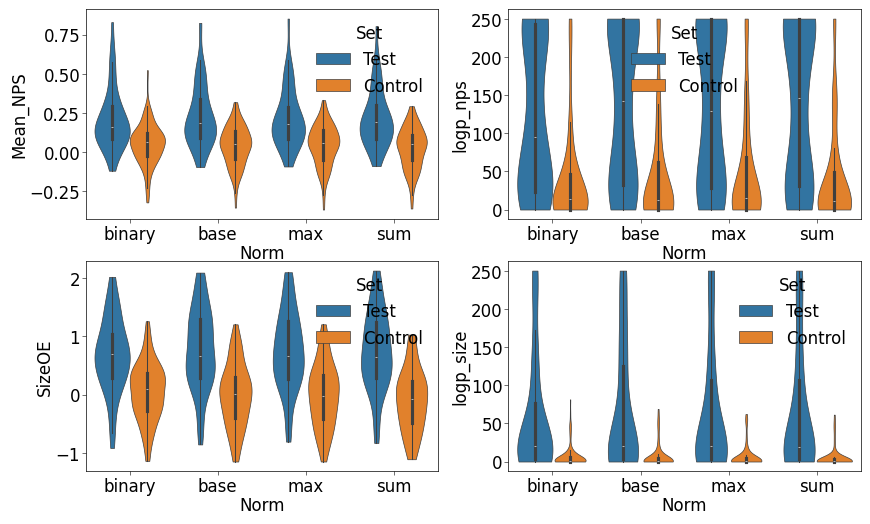

In [114]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
df = pd.concat([all_results[all_results.Group=='nearestGene'], ng]).reset_index()
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    sns.violinplot(df, y=stats[i], x='Norm',hue='Set',cut=0, ax=ax, linewidth=0.5)
print(calculate_auc(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))
print(perform_mann_whitney(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))

### NG8

            Group    Norm       AUC
0  nearestGeneTH8    base  0.793391
1  nearestGeneTH8  binary  0.804167
2  nearestGeneTH8     max  0.793966
3  nearestGeneTH8     sum  0.790643
            Group    Norm  U_statistic   p_value
0  nearestGeneTH8    base       1380.5  0.000003
1  nearestGeneTH8  binary       1447.5  0.000001
2  nearestGeneTH8     max       1381.5  0.000003
3  nearestGeneTH8     sum       1352.0  0.000004


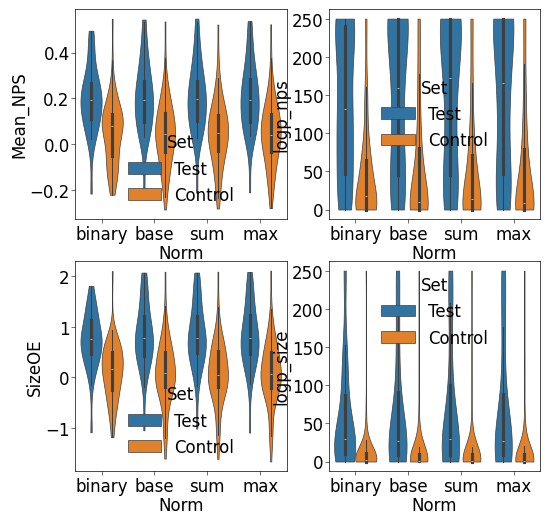

In [115]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6))
df = pd.concat([all_results[all_results.Group=='nearestGeneTH8'], ng8]).reset_index()
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    sns.violinplot(df, y=stats[i], x='Norm',hue='Set',cut=0, ax=ax, linewidth=0.5)
print(calculate_auc(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))
print(perform_mann_whitney(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))

### MAG 103

         Group    Norm       AUC
0  magma_th103    base  0.797906
1  magma_th103  binary  0.781875
2  magma_th103     max  0.803247
3  magma_th103     sum  0.799922
         Group    Norm  U_statistic       p_value
0  magma_th103    base      10022.5  2.738818e-14
1  magma_th103  binary      10008.0  4.864456e-13
2  magma_th103     max       9896.0  1.005104e-14
3  magma_th103     sum      10239.0  1.322661e-14


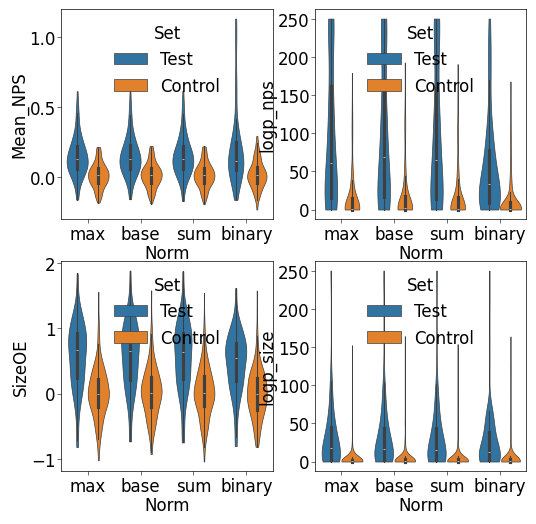

In [116]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6))
df = pd.concat([all_results[all_results.Group=='magma_th103'], mag103]).reset_index()
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    sns.violinplot(df, y=stats[i], x='Norm',hue='Set',cut=0, ax=ax, linewidth=0.5)
print(calculate_auc(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))
print(perform_mann_whitney(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))

### MAG 256

         Group    Norm       AUC
0  magma_th256    base  0.858824
1  magma_th256  binary  0.857008
2  magma_th256     max  0.858912
3  magma_th256     sum  0.855319
         Group    Norm  U_statistic       p_value
0  magma_th256    base       3504.0  2.903095e-12
1  magma_th256  binary       3620.0  2.925544e-12
2  magma_th256     max       3710.5  1.732306e-12
3  magma_th256     sum       3618.0  3.897555e-12


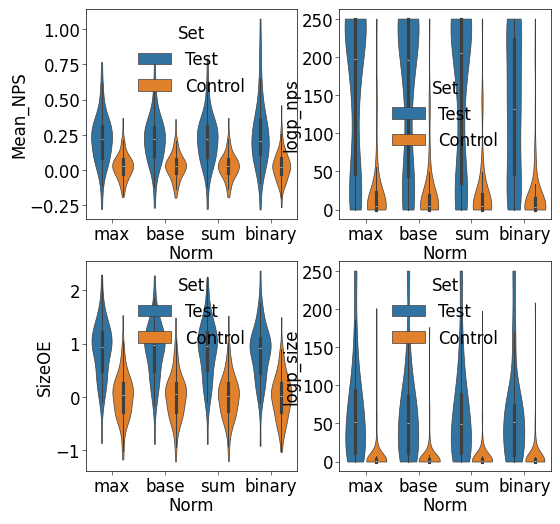

In [117]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6))
df = pd.concat([all_results[all_results.Group=='magma_th256'], mag256]).reset_index()
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    sns.violinplot(df, y=stats[i], x='Norm',hue='Set',cut=0, ax=ax, linewidth=0.5)
print(calculate_auc(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))
print(perform_mann_whitney(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))

### MAG All

       Group  Norm       AUC
0  magma_all  base  0.637209
1  magma_all   max  0.646777
2  magma_all   sum  0.614300
       Group  Norm  U_statistic   p_value
0  magma_all  base       6576.0  0.000022
1  magma_all   max       6623.0  0.000010
2  magma_all   sum       6229.0  0.000327


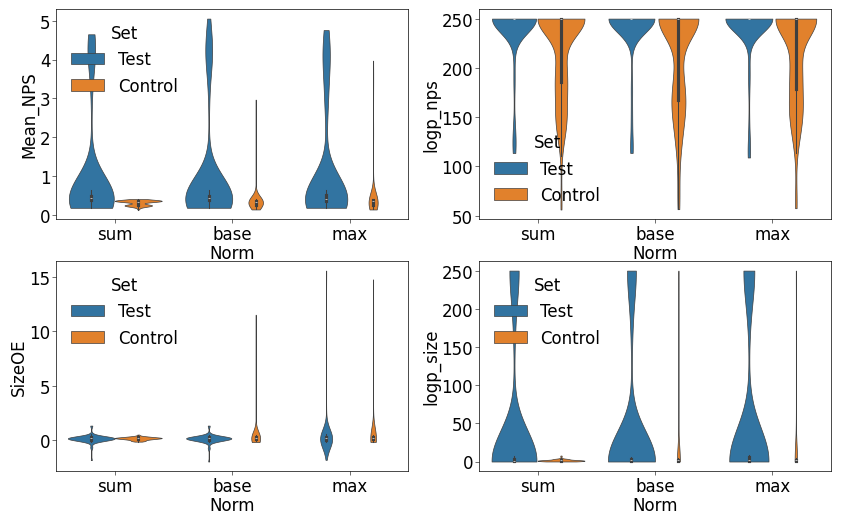

In [118]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
df = pd.concat([all_results[all_results.Group=='magma_all'], magAll]).reset_index()
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    sns.violinplot(df, y=stats[i], x='Norm',hue='Set',cut=0, ax=ax, linewidth=0.5)
print(calculate_auc(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))
print(perform_mann_whitney(df, value_col='logp_nps', processing_col='Group', normalization_col='Norm', control_col='Set', control_labels=('Test', 'Control')))

## Test comparisons

In [119]:
import pandas as pd
from scipy.stats import ttest_rel

def paired_t_test(df, compare_col, method1, method2, value_col, pair_col):
    """
    Perform a paired two-sided t-test between two methods.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        compare_col (str): Column used to identify the methods.
        method1 (str): First method value within the compare_col.
        method2 (str): Second method value within the compare_col.
        value_col (str): Column containing numerical values to be compared.
        pair_col (str): Column used to pair results for comparison.

    Returns:
        dict: t-statistic and p-value from the paired t-test.
    """
    # Filter the dataframe for the two methods
    df_filtered = df[df[compare_col].isin([method1, method2])].dropna(subset=[value_col])
    
    # Pivot to align data for paired comparisons based on the pair_col
    paired_df = df_filtered.pivot(index=pair_col, columns=compare_col, values=value_col)

    # Ensure no missing values in the paired data
    paired_df = paired_df.dropna()

    # Extract the values for the paired t-test
    values1 = paired_df[method1].values
    values2 = paired_df[method2].values

    # Perform paired t-test
    t_stat, p_value = ttest_rel(values1, values2)

    return {
        't_statistic': t_stat,
        'p_value': p_value
    }

from scipy.stats import wilcoxon
import pandas as pd

from scipy.stats import wilcoxon
import pandas as pd
import numpy as np

def paired_wilcoxon_test(df, compare_col, method1, method2, value_col, pair_col):
    """
    Perform a Wilcoxon signed-rank test (non-parametric paired test) between two methods.
    Includes directionality and effect size.

    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        compare_col (str): Column used to identify the methods.
        method1 (str): First method value within the compare_col.
        method2 (str): Second method value within the compare_col.
        value_col (str): Column containing numerical values to be compared.
        pair_col (str): Column used to pair results.

    Returns:
        dict: Wilcoxon signed-rank test statistic, p-value, effect size (rank-biserial correlation),
              and direction of difference.
    """
    # Filter and pivot data to align pairs
    df_filtered = df[df[compare_col].isin([method1, method2])].dropna(subset=[value_col]).reset_index()
    paired_df = df_filtered.pivot(index=pair_col, columns=compare_col, values=value_col)

    # Extract paired values
    values1 = paired_df[method1].values
    values2 = paired_df[method2].values

    # Perform Wilcoxon signed-rank test (two-sided by default)
    stat, p_value = wilcoxon(values1, values2)

    # Calculate effect size (rank-biserial correlation)
    n = len(values1)
    abs_diff = np.abs(values1 - values2)
    rank_biserial = stat / (n * (n + 1) / 2)  # Rank-biserial correlation (effect size)

    # Determine directionality based on mean differences
    mean_diff = np.mean(values1 - values2)
    direction = method1 if mean_diff > 0 else method2

    return {
        'W_statistic': stat,
        'p_value': p_value,
        'effect_size': rank_biserial,  # Rank-biserial correlation
        'direction': f"{direction} has higher values",
        'mean_difference': mean_diff
    }



### Binary vs Q

In [124]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
results = []
for stat in stats:
    for g in groups:
        test_df = all_results[all_results.Group==g]
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts>=4].index.values
        a = paired_t_test(test_df[test_df.Study.isin(use_studies)], compare_col='Norm', method1='binary', 
                      method2='sum', value_col=stat, pair_col='TraitR' )
        a['stat'] = stat
        a['group'] = g
        a['higher'] = 'binary' if a['t_statistic'] > 0 else 'sum'
        results.append(a)
pd.DataFrame(results)

,t_statistic,p_value,stat,group,higher
0,-0.793243,4.317991e-01,Mean_NPS,nearestGene,sum
1,-0.768186,4.485871e-01,Mean_NPS,nearestGeneTH8,sum
2,3.084959,2.805525e-03,Mean_NPS,magma_th103,binary
3,2.566859,1.350679e-02,Mean_NPS,magma_th256,binary
4,-2.864362,6.381281e-03,logp_nps,nearestGene,sum
5,-1.222615,2.313189e-01,logp_nps,nearestGeneTH8,sum
6,-6.784918,2.015625e-09,logp_nps,magma_th103,sum
7,-3.756282,4.840090e-04,logp_nps,magma_th256,sum
8,-2.044201,4.681166e-02,SizeOE,nearestGene,sum
9,-2.331596,2.687611e-02,SizeOE,nearestGeneTH8,sum


In [128]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
results = []
for stat in stats:
    for g in groups:
        test_df = all_results[all_results.Group==g]
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts>=4].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Norm', method1='binary', 
                      method2='sum', value_col=stat, pair_col='TraitR' )
        a['stat'] = stat
        a['group'] = g
        results.append(a)
qb = pd.DataFrame(results)
qb

,W_statistic,p_value,effect_size,direction,mean_difference,stat,group
0,503.0,6.887764e-01,0.465310,sum has higher values,-0.007509,Mean_NPS,nearestGene
1,222.0,8.393927e-01,0.477419,sum has higher values,-0.008903,Mean_NPS,nearestGeneTH8
2,1116.0,1.563489e-02,0.344444,binary has higher values,0.057767,Mean_NPS,magma_th103
3,311.0,3.915033e-03,0.264456,binary has higher values,0.042119,Mean_NPS,magma_th256
4,89.0,3.161765e-03,0.085990,sum has higher values,-18.318002,logp_nps,nearestGene
5,105.0,3.155264e-01,0.225806,sum has higher values,-8.548875,logp_nps,nearestGeneTH8
6,169.0,8.283375e-11,0.053481,sum has higher values,-37.893557,logp_nps,magma_th103
7,99.0,6.896570e-04,0.087766,sum has higher values,-25.860174,logp_nps,magma_th256
8,404.0,1.383609e-01,0.373728,sum has higher values,-0.064173,SizeOE,nearestGene
9,164.0,1.641841e-01,0.352688,sum has higher values,-0.075346,SizeOE,nearestGeneTH8


#### B vs Q plot

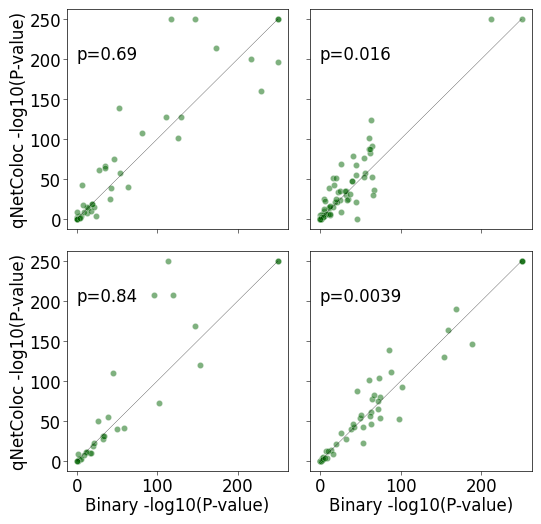

In [132]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2,ax3,ax4]
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, group in enumerate(control_groups.keys()):
    df = all_results[all_results.Group==group]
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.scatterplot(df.pivot(index='Study', columns='Norm', values='logp_size'), y='qNetColoc', x='binary', ax=axs[i], 
                   color='darkgreen', s=20, alpha=0.5, zorder=1, legend=False)
    sns.lineplot(x=[0,250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('Binary -log10(P-value)')
    [ax1,ax2,ax3,ax4][i].set_ylabel('qNetColoc -log10(P-value)')
    for j, norm in enumerate(['binary']):
        p = float('%.2g' % qb[(qb.group==group) & (qb.stat==stat)].p_value.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=-0.45, y=200, s=f'p={p}', fontsize=12)
    #for j, norm in enumerate(['binary', 'sum']):
     #   auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].AUC.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
       # [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=4.5, s=f'AUC={auc}\np={p}', fontsize=8)
plt.savefig(os.path.join(figdir,'SizeP_QvsB_scatter.png'), dpi=400, bbox_inches='tight')

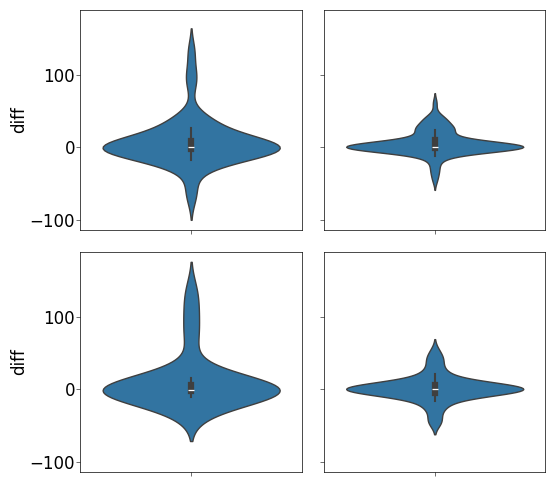

In [133]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2,ax3,ax4]
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, group in enumerate(control_groups.keys()):
    df = all_results[all_results.Group==group]
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    df_pv = df.pivot(index='Study', columns='Norm', values='logp_size')
    df_pv['diff'] = df_pv['qNetColoc'] - df_pv['binary']
    sns.violinplot(df_pv['diff'], ax=axs[i])
    #sns.scatterplot(df.pivot(index='Study', columns='Norm', values='logp_size'), y='qNetColoc', x='binary', ax=axs[i], 
    #               color='lightgreen', s=20, alpha=0.5, zorder=1, legend=False)
    #sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    #[ax1,ax2,ax3,ax4][i].set_xlabel('')
    #[ax1,ax2,ax3,ax4][i].set_ylabel('Colocalized Network\n Size (O/E)')
    #for j, norm in enumerate(['binary', 'sum']):
     #   auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].AUC.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
       # [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=4.5, s=f'AUC={auc}\np={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'SizeOE_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

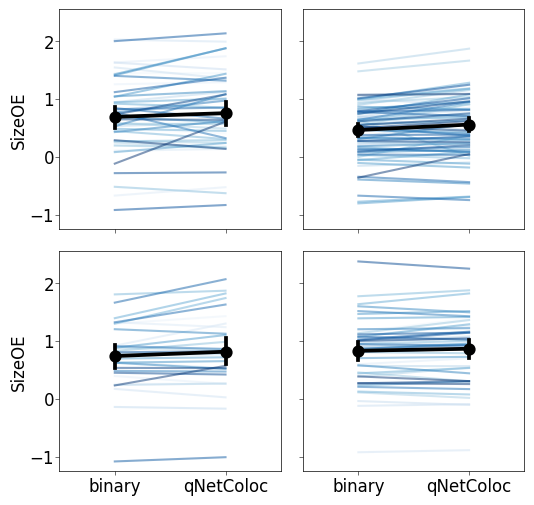

In [134]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2,ax3,ax4]
stat='SizeOE'
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, group in enumerate(control_groups.keys()):
    df = all_results[all_results.Group==group]
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.lineplot(df, y=stat, x='Norm', ax=axs[i], hue='Study', palette='Blues',
                   color='lightgreen', alpha=0.5, zorder=1, legend=False)
    sns.pointplot(df, y=stat, x='Norm', ax=axs[i],
                   color='black', zorder=1, legend=False)
    #sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel(stat)
    #for j, norm in enumerate(['binary', 'sum']):
     #   auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].AUC.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
       # [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=4.5, s=f'AUC={auc}\np={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'SizeOE_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

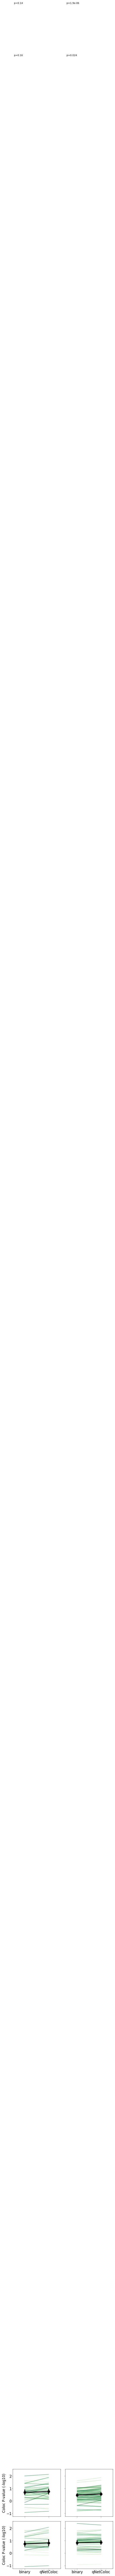

In [135]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2,ax3,ax4]
stat='SizeOE'
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, group in enumerate(control_groups.keys()):
    df = all_results[all_results.Group==group]
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.lineplot(df, y=stat, x='Norm', ax=axs[i], hue='Study', palette='Greens',
                   color='lightgreen', alpha=0.5, zorder=1, legend=False)
    sns.pointplot(df, y=stat, x='Norm', ax=axs[i],
                   color='black', zorder=1, legend=False)
    #sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel('Coloc P-value (-log10)')
    for j, norm in enumerate(['binary']):
        p = float('%.2g' % qb[(qb.group==group) & (qb.stat==stat)].p_value.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=-0.45, y=200, s=f'p={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'SizeP_Paired_Test.png'), dpi=400, bbox_inches='tight')

/tmp/ipykernel_1175151/3276665630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
/tmp/ipykernel_1175151/3276665630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
/tmp/ipykernel_1175151/3276665630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

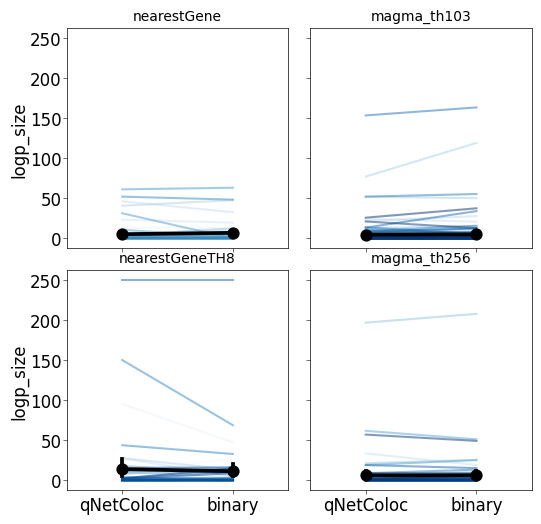

In [136]:
_, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2,ax3,ax4]
stat='logp_size'
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
control_groups = {'nearestGene':ng, 'magma_th103':mag103, 'nearestGeneTH8':ng8, 'magma_th256': mag256}
for i, group in enumerate(control_groups.keys()):
    df = control_groups[group]#all_results[all_results.Group==group]
    df = df[df.Norm.isin(['binary', 'sum'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.lineplot(df, y=stat, x='Norm', ax=axs[i], hue='FullTrait', palette='Blues',
                   color='lightgreen', alpha=0.5, zorder=1, legend=False)
    sns.pointplot(df, y=stat, x='Norm', ax=axs[i],
                   color='black', zorder=1, legend=False)
    #sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    [ax1,ax2,ax3,ax4][i].set_title(group, fontsize=10)
    [ax1,ax2,ax3,ax4][i].set_xlabel('')
    [ax1,ax2,ax3,ax4][i].set_ylabel(stat)
    #for j, norm in enumerate(['binary', 'sum']):
     #   auc = float('%.2g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].AUC.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
       # [ax1,ax2,ax3,ax4][i].text(x=j-0.15, y=4.5, s=f'AUC={auc}\np={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'SizeOE_Control_Test_violins.png'), dpi=400, bbox_inches='tight')

### Across NG vs MG

In [137]:
study_counts = test_df[~test_df[stat].isna()].Study.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Study'

In [138]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'max', 'sum']
results = []
for stat in stats:
    for n in norms:
        test_df = all_results[(all_results.Norm==n) & (all_results.Group.isin(['nearestGene', 'magma_th103']))].dropna()
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts==2].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='nearestGene', 
                      method2='magma_th103', value_col=stat, pair_col='Study' )
        a['stat'] = stat
        a['norm'] = n
        results.append(a)
lenient_df = pd.DataFrame(results)
lenient_df

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm
0,156.0,0.634850,0.444444,magma_th103 has higher values,-0.069800,Mean_NPS,binary
1,145.0,0.452473,0.413105,nearestGene has higher values,0.057576,Mean_NPS,max
2,144.0,0.437447,0.410256,nearestGene has higher values,0.060331,Mean_NPS,sum
3,72.0,0.007291,0.205128,nearestGene has higher values,62.151026,logp_nps,binary
4,117.0,0.220852,0.333333,nearestGene has higher values,34.554790,logp_nps,max
5,103.0,0.179318,0.293447,nearestGene has higher values,36.838420,logp_nps,sum
6,83.0,0.017614,0.236467,nearestGene has higher values,0.311147,SizeOE,binary
7,104.0,0.070921,0.296296,nearestGene has higher values,0.292005,SizeOE,max
8,102.0,0.063030,0.290598,nearestGene has higher values,0.294172,SizeOE,sum
9,96.0,0.043466,0.273504,nearestGene has higher values,40.126849,logp_size,binary


In [43]:
pd.DataFrame(results)

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm
0,156.0,0.634850,0.444444,magma_th103 has higher values,-0.069800,Mean_NPS,binary
1,145.0,0.452473,0.413105,nearestGene has higher values,0.057576,Mean_NPS,max
2,144.0,0.437447,0.410256,nearestGene has higher values,0.060331,Mean_NPS,sum
3,72.0,0.007291,0.205128,nearestGene has higher values,62.151026,logp_nps,binary
4,117.0,0.220852,0.333333,nearestGene has higher values,34.554790,logp_nps,max
5,103.0,0.179318,0.293447,nearestGene has higher values,36.838420,logp_nps,sum
6,80.0,0.014006,0.227920,nearestGene has higher values,0.460409,SizeOE,binary
7,95.0,0.040747,0.270655,nearestGene has higher values,0.501127,SizeOE,max
8,93.0,0.035724,0.264957,nearestGene has higher values,0.501897,SizeOE,sum
9,96.0,0.043466,0.273504,nearestGene has higher values,40.126849,logp_size,binary


In [139]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'max', 'sum']
results = []
for stat in stats:
    for n in norms:
        test_df = all_results[(all_results.Norm==n) & (all_results.Group.isin(['nearestGeneTH8', 'magma_th256']))].dropna()
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts==2].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='nearestGeneTH8', 
                      method2='magma_th256', value_col=stat, pair_col='Study' )
        a['stat'] = stat
        a['norm'] = n
        results.append(a)
strict_df = pd.DataFrame(results)
strict_df

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm
0,48.0,0.524475,0.400000,magma_th256 has higher values,-0.049674,Mean_NPS,binary
1,51.0,0.638672,0.425000,nearestGeneTH8 has higher values,0.043218,Mean_NPS,max
2,49.0,0.561401,0.408333,nearestGeneTH8 has higher values,0.045458,Mean_NPS,sum
3,37.0,0.330536,0.308333,nearestGeneTH8 has higher values,30.283093,logp_nps,binary
4,34.0,0.694887,0.283333,nearestGeneTH8 has higher values,19.894323,logp_nps,max
5,28.0,0.656642,0.233333,nearestGeneTH8 has higher values,25.368966,logp_nps,sum
6,42.0,0.330261,0.350000,nearestGeneTH8 has higher values,0.146522,SizeOE,binary
7,36.0,0.187622,0.300000,nearestGeneTH8 has higher values,0.251350,SizeOE,max
8,33.0,0.135376,0.275000,nearestGeneTH8 has higher values,0.275722,SizeOE,sum
9,54.0,0.761536,0.450000,nearestGeneTH8 has higher values,11.367385,logp_size,binary


In [227]:
all_results

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,Study,q,Group,Threshold,Method,EFOStudy,logp_nps,logp_size,SizeOE,Set
0,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,max,0.291539,0.003797,0.000000e+00,476,199.826,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.568475,1.252217,Test
1,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,base,0.290418,0.003738,9.460000e-300,473,201.207,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.790753,1.233160,Test
2,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,sum,0.291886,0.003489,5.237000e-303,477,204.009,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,92.288024,1.225356,Test
3,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,max,0.222286,0.000150,9.976000e-232,498,196.502,...,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,231.001044,121.634512,1.341602,Test
4,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,base,0.212583,-0.000134,5.115000e-197,488,198.591,...,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,196.291154,112.771600,1.297081,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,EFO_0004741_GCST90278623,EFO_0004741_GCST90278623,pcnet2_0,neglog10,sum,0.140795,-0.002172,3.271000e-95,279,193.233,...,GCST90278623,True,nearestGeneTH8,High,NG,EFO_0004741:GCST90278623,94.485319,11.612077,0.529924,Test
1223,EFO_0004741_GCST90278623,EFO_0004741_GCST90278623,pcnet2_0,neglog10,max,0.132056,-0.001860,1.016000e-77,266,191.646,...,GCST90278623,True,nearestGeneTH8,High,NG,EFO_0004741:GCST90278623,76.993106,8.221921,0.472982,Test
1224,EFO_0600008_GCST90268467,EFO_0600008_GCST90268467,pcnet2_0,neglog10,max,0.175350,0.029909,1.490000e-101,181,122.020,...,GCST90268467,True,nearestGeneTH8,High,NG,EFO_0600008:GCST90268467,100.826814,8.222573,0.568872,Test
1225,EFO_0600008_GCST90268467,EFO_0600008_GCST90268467,pcnet2_0,neglog10,sum,0.173562,0.029342,2.999000e-97,180,121.319,...,GCST90268467,True,nearestGeneTH8,High,NG,EFO_0600008:GCST90268467,96.523024,8.754981,0.569191,Test


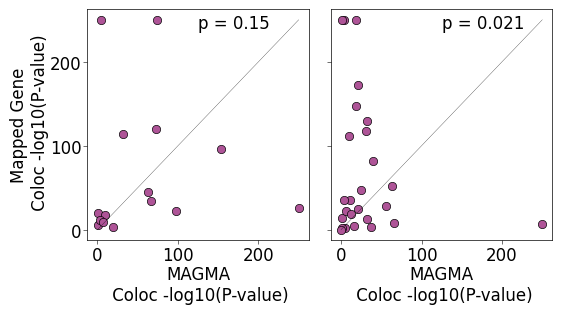

In [163]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2]
stat='logp_size'
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, th in enumerate(['High' , 'Low']):
    df = all_results[all_results.Threshold==th]
    df = df[df.Norm.isin(['binary'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.scatterplot(df.pivot(index='Study', columns='Method', values=stat), y='NG', x='MAGMA', ax=axs[i],
                   color='#AE5497', alpha=1, zorder=1, legend=False, edgecolor='black')
    #sns.pointplot(df, y=stat, x='Method', ax=axs[i],
     #              color='black', zorder=1, legend=False)
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(th, fontsize=10)
    [ax1,ax2][i].set_xlabel('MAGMA\n Coloc -log10(P-value)')
    [ax1,ax2][i].set_ylabel('Mapped Gene\n Coloc -log10(P-value)')
    [ax1,ax2][i].set_xticks([0,100, 200])
    [ax1,ax2][i].set_yticks([0,100, 200])
    for j, norm in enumerate(['binary']):
        if th == 'High':
            p = float('%.2g' % strict_df[(strict_df.norm=='sum') & (strict_df.stat==stat)].p_value.values[0])
            diff = float('%.2g' % strict_df[(strict_df.norm=='sum') & (strict_df.stat==stat)].mean_difference.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        else:
            p = float('%.2g' % lenient_df[(lenient_df.norm=='sum') & (lenient_df.stat==stat)].p_value.values[0])
            diff = float('%.2g' % lenient_df[(lenient_df.norm=='sum') & (lenient_df.stat==stat)].mean_difference.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=125, y=240, s=f'p = {p}', fontsize=12)
    #for j, norm in enumerate(['binary']):
        #p = float('%.2g' % qb[(qb.group==group) & (qb.stat==stat)].p_value.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        #[ax1,ax2,ax3,ax4][i].text(x=-0.45, y=200, s=f'p={p}', fontsize=8)
plt.savefig(os.path.join(figdir,'NG_vs_MAGMA.png'), dpi=400, bbox_inches='tight')

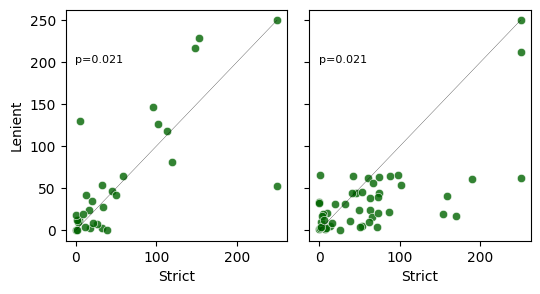

### Thresholds

In [155]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'max', 'sum']
results = []
for stat in stats:
    for n in norms:
        test_df = all_results[(all_results.Norm==n) & (all_results.Group.isin(['nearestGene', 'nearestGeneTH8']))].dropna()
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts==2].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='nearestGeneTH8', 
                      method2='nearestGene', value_col=stat, pair_col='Study' )
        a['stat'] = stat
        a['norm'] = n
        results.append(a)
ng_th = pd.DataFrame(results)

In [156]:
ng_th

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm
0,169.0,0.198076,0.363441,nearestGene has higher values,-0.023548,Mean_NPS,binary
1,159.0,0.213245,0.365517,nearestGene has higher values,-0.020744,Mean_NPS,max
2,172.0,0.220647,0.369892,nearestGene has higher values,-0.022659,Mean_NPS,sum
3,151.0,0.756995,0.324731,nearestGeneTH8 has higher values,5.673148,logp_nps,binary
4,94.0,0.454889,0.216092,nearestGene has higher values,-7.479789,logp_nps,max
5,100.0,0.590064,0.215054,nearestGene has higher values,-8.609486,logp_nps,sum
6,202.0,0.542528,0.434409,nearestGene has higher values,-0.045745,SizeOE,binary
7,183.0,0.467938,0.420690,nearestGene has higher values,-0.051826,SizeOE,max
8,185.0,0.338742,0.397849,nearestGene has higher values,-0.065060,SizeOE,sum
9,173.0,0.335933,0.372043,nearestGene has higher values,-3.604685,logp_size,binary


In [157]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'max', 'sum']
results = []
for stat in stats:
    for n in norms:
        test_df = all_results[(all_results.Norm==n) & (all_results.Group.isin(['magma_th103', 'magma_th256']))].dropna()
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts==2].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='magma_th103', 
                      method2='magma_th256', value_col=stat, pair_col='Study' )
        a['stat'] = stat
        a['norm'] = n
        results.append(a)
mag_th = pd.DataFrame(results)

In [158]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'max', 'sum']
results = []

for stat in stats:
    for n in norms:
        test_df = all_results[(all_results.Norm==n) & (all_results.Group.isin(['nearestGene', 'magma_th256']))].dropna()
        study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
        use_studies = study_counts[study_counts==2].index.values
        a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='nearestGene', 
                      method2='magma_th256', value_col=stat, pair_col='Study' )
        a['stat'] = stat
        a['norm'] = n
        results.append(a)
pd.DataFrame(results)

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm
0,98.0,0.812355,0.466667,magma_th256 has higher values,-0.007500,Mean_NPS,binary
1,79.0,0.348810,0.376190,nearestGene has higher values,0.064453,Mean_NPS,max
2,75.0,0.277355,0.357143,nearestGene has higher values,0.068712,Mean_NPS,sum
3,66.0,0.395696,0.314286,nearestGene has higher values,26.987692,logp_nps,binary
4,72.0,0.556533,0.342857,nearestGene has higher values,26.300519,logp_nps,max
5,63.0,0.522723,0.300000,nearestGene has higher values,28.660599,logp_nps,sum
6,79.0,0.348810,0.376190,nearestGene has higher values,0.165484,SizeOE,binary
7,65.0,0.142906,0.309524,nearestGene has higher values,0.261242,SizeOE,max
8,58.0,0.082550,0.276190,nearestGene has higher values,0.281674,SizeOE,sum
9,81.0,0.388376,0.385714,nearestGene has higher values,21.613880,logp_size,binary


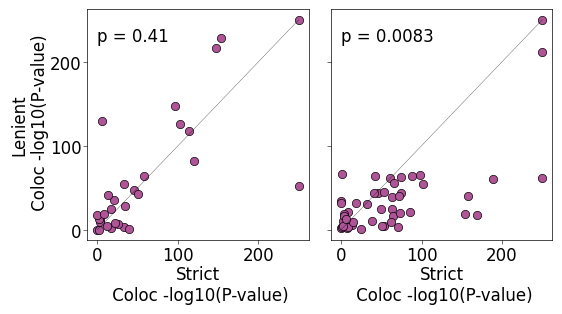

In [166]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6,3), sharex=True, sharey=True, 
                                           gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs=[ax1,ax2]
stat='logp_size'
groups = ['nearestGene', 'nearestGeneTH8', 'magma_th103', 'magma_th256']
for i, th in enumerate(['NG' , 'MAGMA']):
    df = all_results[all_results.Method==th]
    df = df[df.Norm.isin(['binary'])]
    df['Norm'] = df['Norm'].map({'binary':'binary', 'sum':'qNetColoc'})
    sns.scatterplot(df.pivot(index='Study', columns='Threshold', values=stat), x='High', y='Low', ax=axs[i],
                   color='#AE5497', alpha=1, zorder=1, legend=False, edgecolor='black')
    #sns.pointplot(df, y=stat, x='Method', ax=axs[i],
     #              color='black', zorder=1, legend=False)
    sns.lineplot(x=[0, 250], y=[0,250], ax=axs[i], color='black', linewidth=0.2)
    #[ax1,ax2,ax3,ax4][i].set_title(th, fontsize=10)
    [ax1,ax2][i].set_xlabel('Strict\n Coloc -log10(P-value)')
    [ax1,ax2][i].set_ylabel('Lenient\n Coloc -log10(P-value)')
    [ax1,ax2][i].set_xticks([0,100, 200])
    [ax1,ax2][i].set_yticks([0,100, 200])
    for j, norm in enumerate(['binary']):
        if th == 'NG':
            p = float('%.2g' % ng_th[(ng_th.norm=='sum') & (ng_th.stat==stat)].p_value.values[0])
            diff = float('%.2g' % ng_th[(ng_th.norm=='sum') & (ng_th.stat==stat)].mean_difference.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        else:
            p = float('%.2g' % mag_th[(mag_th.norm=='sum') & (mag_th.stat==stat)].p_value.values[0])
            diff = float('%.2g' % mag_th[(mag_th.norm=='sum') & (mag_th.stat==stat)].mean_difference.values[0])
        [ax1,ax2,ax3,ax4][i].text(x=-0.45, y=225, s=f'p = {p}', fontsize=12)
    #for j, norm in enumerate(['binary']):
        #p = float('%.2g' % qb[(qb.group==group) & (qb.stat==stat)].p_value.values[0])
      #  p = float('%.1g' % res_df[(res_df.Group==group) & (res_df.Norm==norm) & (res_df.stat=='SizeOE')].p_value.values[0])
        #[ax1,ax2,ax3,ax4][i].text(x=-0.45, y=200, s=f'p={p}', fontsize=8)
#plt.savefig(os.path.join(figdir,'High_vs_Low.png'), dpi=400, bbox_inches='tight')

In [275]:
import pingouin as pg

def two_way_repeated_measures_anova(df, value_col, subject_col, factor1_col, factor2_col):
    """
    Perform a two-way repeated measures ANOVA.
    
    Args:
        df (pd.DataFrame): Input dataframe containing the data.
        value_col (str): Column containing the dependent variable (numerical values).
        subject_col (str): Column identifying the subjects (pairs) for repeated measures.
        factor1_col (str): Column specifying the first independent variable (e.g., processing method).
        factor2_col (str): Column specifying the second independent variable (e.g., normalization method).
    
    Returns:
        pd.DataFrame: ANOVA summary table with F-values, p-values, and effect sizes.
    """
    # Perform two-way repeated measures ANOVA
    anova_results = pg.rm_anova(
        data=df,
        dv=value_col,
        subject=subject_col,
        within=[factor1_col, factor2_col],
        detailed=True
    )
    return anova_results


In [280]:
anova_df = all_results[all_results.Norm=='sum'].dropna(subset='logp_size')
study_counts = anova_df.Study.value_counts()
keep_studies = study_counts[study_counts == 4].index.values

two_way_repeated_measures_anova(anova_df[anova_df.Study.isin(keep_studies)], value_col='logp_size', subject_col='Study',
                               factor1_col='Threshold', factor2_col='Method')

/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/cellar/users/snwright/anaconda3/envs/carva/lib/python3.10/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Threshold,233926.414534,2,8,116963.207267,129.714454,8.008046e-07,0.000029,0.851605,0.701009
1,Method,1254.789293,1,4,1254.789293,0.070101,8.042733e-01,0.804273,0.029864,1.000000
2,Threshold * Method,-82345.645979,2,8,-41172.822990,5.062910,3.794629e-02,0.037946,1.980265,1.000000


In [284]:
all_results.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,...,Study,q,Group,Threshold,Method,EFOStudy,logp_nps,logp_size,SizeOE,Set
0,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,max,0.291539,0.003797,0.000000e+00,476,199.826,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.568475,1.252217,Test
1,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,base,0.290418,0.003738,9.460000e-300,473,201.207,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,100.790753,1.233160,Test
2,GCST001791_EFO_0004531,GCST001791_EFO_0004531,pcnet2_0,neglog10,sum,0.291886,0.003489,5.237000e-303,477,204.009,...,GCST001791,True,magma_th256,High,MAGMA,EFO_0004531:GCST001791,250.000000,92.288024,1.225356,Test
3,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,max,0.222286,0.000150,9.976000e-232,498,196.502,...,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,231.001044,121.634512,1.341602,Test
4,GCST006366_EFO_0005213,GCST006366_EFO_0005213,pcnet2_0,neglog10,base,0.212583,-0.000134,5.115000e-197,488,198.591,...,GCST006366,True,magma_th256,High,MAGMA,EFO_0005213:GCST006366,196.291154,112.771600,1.297081,Test


## Repeats

In [48]:
ng_reps =pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/nearestGene_all_repeat_results.tsv', sep='\t')
mag_reps=pd.read_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/magma_all_repeat_results.tsv',  sep='\t')
ng_reps['Set'] = 'Test'
ng_reps['Group'] = ng_reps['Group'].map({'NG':'nearestGene', 'NG3':'nearestGeneTH8'})
mag_reps['Set'] = 'Test'
mag_reps['Group'] = mag_reps['Group'].map({'MAG':'magma_th103', 'MAG256': 'magma_th256'})

### AUC

In [49]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
control_groups = {'nearestGene':ng, 'magma_th103':mag103}
rep_groups = {'nearestGene': ng_reps, 'magma_th103': mag_reps}
norm_methods = ['sum', 'binary', 'base']
results = []
for stat in stats:
    for g, g_df in control_groups.items():
        for rep in [1,2,3]:
            test_df = rep_groups[g][(rep_groups[g].repeat==rep)]
            study_counts = test_df[~test_df[stat].isna()].TraitR.value_counts()
            use_studies = study_counts[study_counts>=3].index.values
            #print(len(use_studies)/len(study_counts))
            test_df = test_df[test_df.TraitR.isin(use_studies)]
            control_df = g_df.copy()
            control_counts = g_df[~g_df[stat].isna()].FullTrait.value_counts()
            use_controls= control_counts[control_counts==4].index.values
            control_df = control_df[(control_df.FullTrait.isin(use_controls)) & (control_df.Norm.isin(norm_methods))]
            df = pd.concat([test_df, control_df]).reset_index()
            mannu = perform_mann_whitney(df, value_col=stat, processing_col='Group', normalization_col='Norm', 
                                       control_col='Set', control_labels=('Test', 'Control'))
            auc = calculate_auc(df, value_col=stat, processing_col='Group', normalization_col='Norm', 
                                control_col='Set', control_labels=('Test', 'Control'))

            res = auc.merge(mannu, on=['Group', 'Norm'], how='outer')
            res['stat'] = stat
            res['repeat'] = rep
            results.append(res)

In [50]:
rep_res = pd.concat(results)

In [51]:
rep_res.query('Group == "nearestGene"').query('Norm == "sum"')

,Group,Norm,AUC,U_statistic,p_value,stat,repeat
2,nearestGene,sum,0.789596,2034.0,2.671523e-07,Mean_NPS,1
2,nearestGene,sum,0.814441,1049.0,6.349718e-06,Mean_NPS,2
2,nearestGene,sum,0.732143,984.0,5.368967e-04,Mean_NPS,3
2,nearestGene,sum,0.780474,2010.5,5.164715e-07,logp_nps,1
2,nearestGene,sum,0.817776,1007.5,6.212314e-06,logp_nps,2
2,nearestGene,sum,0.732919,944.0,5.652020e-04,logp_nps,3
2,nearestGene,sum,0.833075,2146.0,4.040076e-09,SizeOE,1
2,nearestGene,sum,0.871118,1122.0,1.281684e-07,SizeOE,2
2,nearestGene,sum,0.816220,1097.0,4.159005e-06,SizeOE,3
2,nearestGene,sum,0.831910,2143.0,4.073749e-09,logp_size,1


In [52]:
rep_res.query('Group == "magma_th103"').groupby(['stat', 'Norm']).AUC.mean()

stat       Norm  
Mean_NPS   base      0.822104
           binary    0.814797
           sum       0.818809
SizeOE     base      0.823847
           binary    0.813054
           sum       0.821696
logp_nps   base      0.823460
           binary    0.805299
           sum       0.823809
logp_size  base      0.822024
           binary    0.811601
           sum       0.818697
Name: AUC, dtype: float64

### Paired tests
#### Q vs binary

In [53]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
rep_groups = {'nearestGene': ng_reps, 'magma_th103': mag_reps}
results = []
for stat in stats:
    for g, g_df in rep_groups.items():
        for rep in [1,2,3]:
            test_df = g_df[(g_df.Group==g) & (g_df.repeat==rep)]
            study_counts = test_df[~test_df[stat].isna()].TraitR.value_counts()
            use_studies = study_counts[study_counts>=3].index.values
            a = paired_wilcoxon_test(test_df[test_df.TraitR.isin(use_studies)], compare_col='Norm', method1='binary', 
                          method2='sum', value_col=stat, pair_col='TraitR' )
            a['stat'] = stat
            a['group'] = g
            a['rep'] = rep
            results.append(a)
pd.DataFrame(results)

,W_statistic,p_value,effect_size,direction,mean_difference,stat,group,rep
0,503.0,6.887764e-01,0.465310,sum has higher values,-0.007509,Mean_NPS,nearestGene,1
1,125.0,7.090142e-01,0.452899,sum has higher values,-0.022461,Mean_NPS,nearestGene,2
2,133.0,6.431422e-01,0.443333,sum has higher values,-0.001246,Mean_NPS,nearestGene,3
3,1116.0,1.563489e-02,0.344444,binary has higher values,0.057767,Mean_NPS,magma_th103,1
4,35.0,4.944801e-04,0.116667,binary has higher values,0.121171,Mean_NPS,magma_th103,2
5,18.0,3.015995e-05,0.060000,binary has higher values,0.127443,Mean_NPS,magma_th103,3
6,90.0,1.959823e-03,0.083256,sum has higher values,-19.173439,logp_nps,nearestGene,1
7,30.0,4.942197e-02,0.118577,sum has higher values,-20.351959,logp_nps,nearestGene,2
8,49.0,1.119277e-01,0.177536,sum has higher values,-14.627870,logp_nps,nearestGene,3
9,169.0,8.283375e-11,0.053481,sum has higher values,-37.893557,logp_nps,magma_th103,1


In [54]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
rep_groups = {'nearestGene': ng_reps, 'magma_th103': mag_reps}
results = []
for stat in stats:
    for g, g_df in rep_groups.items():
        for rep in [1,2,3]:
            test_df = g_df[(g_df.Group==g) & (g_df.repeat==rep)]
            study_counts = test_df[~test_df[stat].isna()].TraitR.value_counts()
            use_studies = study_counts[study_counts>=3].index.values
            a = paired_wilcoxon_test(test_df[test_df.TraitR.isin(use_studies)].dropna(),
                                     compare_col='Norm', method1='binary', 
                          method2='base', value_col=stat, pair_col='TraitR' )
            a['stat'] = stat
            a['group'] = g
            a['rep'] = rep
            results.append(a)
pd.DataFrame(results)

,W_statistic,p_value,effect_size,direction,mean_difference,stat,group,rep
0,500.0,6.649943e-01,0.462535,base has higher values,-0.006128,Mean_NPS,nearestGene,1
1,124.0,6.868792e-01,0.449275,base has higher values,-0.021353,Mean_NPS,nearestGene,2
2,NaN,NaN,NaN,base has higher values,NaN,Mean_NPS,nearestGene,3
3,NaN,NaN,NaN,base has higher values,NaN,Mean_NPS,magma_th103,1
4,35.0,4.944801e-04,0.116667,binary has higher values,0.121861,Mean_NPS,magma_th103,2
5,21.0,5.328655e-05,0.070000,binary has higher values,0.127615,Mean_NPS,magma_th103,3
6,78.0,8.640641e-04,0.072155,base has higher values,-18.205114,logp_nps,nearestGene,1
7,27.0,3.400103e-02,0.106719,base has higher values,-20.842909,logp_nps,nearestGene,2
8,47.0,9.360337e-02,0.170290,base has higher values,-15.866257,logp_nps,nearestGene,3
9,140.0,4.454061e-11,0.044304,base has higher values,-38.845467,logp_nps,magma_th103,1


#### Magma vs NG

In [55]:
all_reps= pd.concat([ng_reps, mag_reps])
all_reps = all_reps.assign(Study=all_reps.TraitR.apply(lambda z: next((match.group() for match in re.finditer(r'GCST\d+', z)), None)))

In [56]:
all_reps.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,repeat,logp_nps,logp_size,SizeOE,Group,Set,Study
0,nearestGene_EFO_0000731_GCST009158,nearestGene_EFO_0000731_GCST009158,pcnet2_0,neglog10,binary,0.146290,-0.001231,7.886000e-76,278,198.901,4.989000e-10,1,75.103143,9.301986,1.397680,nearestGene,Test,GCST009158
1,nearestGene_EFO_0000731_GCST90018714,nearestGene_EFO_0000731_GCST90018714,pcnet2_0,neglog10,binary,0.163959,-0.001439,2.208000e-108,399,234.931,1.157000e-35,1,107.656001,34.936667,1.698371,nearestGene,Test,GCST90018714
2,nearestGene_EFO_0000731_GCST90018934,nearestGene_EFO_0000731_GCST90018934,pcnet2_0,neglog10,binary,0.289598,0.000365,1.012000e-223,445,248.431,2.588000e-42,1,222.994819,41.587036,1.791242,nearestGene,Test,GCST90018934
3,nearestGene_EFO_0004237_GCST90018627,nearestGene_EFO_0004237_GCST90018627,pcnet2_0,neglog10,binary,0.045040,-0.002468,1.116000e-13,162,112.422,1.143000e-07,1,12.952336,6.941954,1.440999,nearestGene,Test,GCST90018627
4,nearestGene_EFO_0004237_GCST90018847,nearestGene_EFO_0004237_GCST90018847,pcnet2_0,neglog10,binary,0.264360,0.000466,0.000000e+00,489,185.565,3.389000e-127,1,250.000000,126.469928,2.635195,nearestGene,Test,GCST90018847


In [57]:
stats = ['Mean_NPS', 'logp_nps', 'SizeOE', 'logp_size']
norms = ['binary', 'base', 'sum']
results = []
for stat in stats:
    for n in norms:
        for rep in [1,2,3]:
            test_df = all_reps[(all_reps.Norm==n) & (all_reps.Group.isin(['nearestGene', 'magma_th103'])) & (all_reps.repeat==rep)].dropna()
            study_counts = test_df[~test_df[stat].isna()].Study.value_counts()
            use_studies = study_counts[study_counts==2].index.values
            a = paired_wilcoxon_test(test_df[test_df.Study.isin(use_studies)], compare_col='Group', method1='nearestGene', 
                          method2='magma_th103', value_col=stat, pair_col='Study' )
            a['stat'] = stat
            a['norm'] = n
            a['rep'] = rep
            results.append(a)
pd.DataFrame(results)

,W_statistic,p_value,effect_size,direction,mean_difference,stat,norm,rep
0,156.0,0.634850,0.444444,magma_th103 has higher values,-0.069800,Mean_NPS,binary,1
1,100.0,0.259452,0.362319,magma_th103 has higher values,-0.125534,Mean_NPS,binary,2
2,94.0,0.113961,0.313333,magma_th103 has higher values,-0.145987,Mean_NPS,binary,3
3,126.0,0.338788,0.387692,nearestGene has higher values,0.066559,Mean_NPS,base,1
4,137.0,0.988101,0.496377,nearestGene has higher values,0.025250,Mean_NPS,base,2
5,113.0,0.463381,0.409420,magma_th103 has higher values,-0.023688,Mean_NPS,base,3
6,144.0,0.437447,0.410256,nearestGene has higher values,0.060331,Mean_NPS,sum,1
7,101.0,0.633297,0.437229,nearestGene has higher values,0.054399,Mean_NPS,sum,2
8,127.0,0.527059,0.423333,magma_th103 has higher values,-0.017297,Mean_NPS,sum,3
9,72.0,0.007291,0.205128,nearestGene has higher values,62.151026,logp_nps,binary,1


In [58]:
test_df[test_df.Study.isin(use_studies)]

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,repeat,logp_nps,logp_size,SizeOE,Group,Set,Study
248,nearestGene_EFO_0000731_GCST90018714,nearestGene_EFO_0000731_GCST90018714,pcnet2_0,neglog10,sum,0.247288,0.001136,3.879000e-289,408,197.422,2.950000e-56,3,250.000000,55.530178,2.066639,nearestGene,Test,GCST90018714
250,nearestGene_EFO_0004237_GCST90018627,nearestGene_EFO_0004237_GCST90018627,pcnet2_0,neglog10,sum,0.057534,-0.039561,5.709000e-48,160,139.167,2.378000e-02,3,47.243440,1.623788,1.149698,nearestGene,Test,GCST90018627
252,nearestGene_EFO_0004343_GCST90103754,nearestGene_EFO_0004343_GCST90103754,pcnet2_0,neglog10,sum,0.015258,0.006726,1.199000e-01,236,235.419,4.830000e-01,3,0.921181,0.316053,1.002468,nearestGene,Test,GCST90103754
254,nearestGene_EFO_0004343_GCST90278649,nearestGene_EFO_0004343_GCST90278649,pcnet2_0,neglog10,sum,0.054725,0.002187,6.289000e-15,255,214.660,1.119000e-03,3,14.201418,2.951170,1.187925,nearestGene,Test,GCST90278649
256,nearestGene_EFO_0004741_GCST008062,nearestGene_EFO_0004741_GCST008062,pcnet2_0,neglog10,sum,0.121294,0.000890,1.160000e-71,267,210.777,1.321000e-05,3,70.935542,4.879097,1.266742,nearestGene,Test,GCST008062
258,nearestGene_EFO_0004741_GCST90018728,nearestGene_EFO_0004741_GCST90018728,pcnet2_0,neglog10,sum,-0.064190,0.001308,1.000000e+00,182,162.993,4.837000e-02,3,-0.000000,1.315424,1.116612,nearestGene,Test,GCST90018728
260,nearestGene_EFO_0004741_GCST90103632,nearestGene_EFO_0004741_GCST90103632,pcnet2_0,neglog10,sum,0.082613,-0.002505,4.895000e-31,293,218.161,1.023000e-08,3,30.310247,7.990124,1.343045,nearestGene,Test,GCST90103632
262,nearestGene_EFO_0004741_GCST90278623,nearestGene_EFO_0004741_GCST90278623,pcnet2_0,neglog10,sum,0.162282,-0.006061,3.331000e-116,256,207.377,8.897000e-05,3,115.477425,4.050756,1.234467,nearestGene,Test,GCST90278623
264,nearestGene_EFO_0004887_GCST90093316,nearestGene_EFO_0004887_GCST90093316,pcnet2_0,neglog10,sum,0.110069,-0.019439,5.129000e-39,309,328.129,8.880000e-01,3,38.289967,0.051587,0.941703,nearestGene,Test,GCST90093316
266,nearestGene_EFO_0005213_GCST006366,nearestGene_EFO_0005213_GCST006366,pcnet2_0,neglog10,sum,0.226112,0.000161,2.730000e-271,440,153.838,2.622000e-138,3,250.000000,137.581367,2.860152,nearestGene,Test,GCST006366
